<a href="https://colab.research.google.com/github/yethegod/Cifar10_Resnet18/blob/main/Resnet_Cifar10_pre_activation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)


test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


Using device: cuda


In [35]:
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()

    self.bn1 = nn.BatchNorm2d(in_planes)
    self.relu = nn.ReLU(inplace=True)
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

    if stride != 1 or in_planes != self.expansion * planes:
      self.shortcut = nn.Sequential(
        nn.Conv2d(in_planes, self.expansion * planes, 1, stride, bias=False),
        nn.BatchNorm2d(self.expansion * planes)
    )
    else:
      self.shortcut = nn.Sequential()


  def forward(self, x):
    out = self.bn1(x)
    out = self.relu(out)
    out = self.conv1(out)
    out = self.bn2(out)
    out = self.relu(out)
    out = self.conv2(out)
    out += self.shortcut(x)
    return out

In [42]:
class resnet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(resnet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512 * block.expansion, num_classes)

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
      elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for s in strides:
      layers.append(block(self.in_planes, planes, s))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)

    x = self.bn1(x)
    x = self.relu(x)


    x = self.layer1(x)

    x = self.layer2(x)

    x = self.layer3(x)

    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

In [43]:
def resnet18(num_classes=10):
  return resnet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [44]:
model = resnet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

In [45]:
def train_one_epoch(model, criterion, optimizer, train_loader, device):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()*inputs.size(0)
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

  epoch_loss = running_loss / total
  epoch_acc = correct / total
  return epoch_loss, epoch_acc

In [46]:
def evaluate(model, criterion, test_loader, device):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      running_loss += loss.item()*inputs.size(0)
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  epoch_loss = running_loss / total
  epoch_acc = correct / total
  return epoch_loss, epoch_acc

In [47]:
import matplotlib.pyplot as plt

num_epochs = 50

train_loss_history = []
test_loss_history = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, criterion, optimizer, train_loader, device)
    test_loss, test_acc = evaluate(model, criterion, test_loader, device)


    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}| "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}")


    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)

Epoch [1/50] Train Loss: 6.9964, Train Acc: 0.11| Test Loss: 2.2520, Test Acc: 0.16
Epoch [2/50] Train Loss: 2.0913, Train Acc: 0.20| Test Loss: 1.9474, Test Acc: 0.23
Epoch [3/50] Train Loss: 1.9131, Train Acc: 0.25| Test Loss: 1.7577, Test Acc: 0.31
Epoch [4/50] Train Loss: 1.7505, Train Acc: 0.32| Test Loss: 1.7333, Test Acc: 0.34
Epoch [5/50] Train Loss: 1.6357, Train Acc: 0.38| Test Loss: 1.6274, Test Acc: 0.40
Epoch [6/50] Train Loss: 1.5133, Train Acc: 0.43| Test Loss: 1.5452, Test Acc: 0.43
Epoch [7/50] Train Loss: 1.3719, Train Acc: 0.50| Test Loss: 1.3236, Test Acc: 0.52
Epoch [8/50] Train Loss: 1.1783, Train Acc: 0.57| Test Loss: 1.9328, Test Acc: 0.45
Epoch [9/50] Train Loss: 1.0087, Train Acc: 0.64| Test Loss: 1.2884, Test Acc: 0.57
Epoch [10/50] Train Loss: 0.8578, Train Acc: 0.70| Test Loss: 1.5912, Test Acc: 0.56
Epoch [11/50] Train Loss: 0.7634, Train Acc: 0.74| Test Loss: 1.0480, Test Acc: 0.64
Epoch [12/50] Train Loss: 0.6949, Train Acc: 0.76| Test Loss: 0.7026, Test

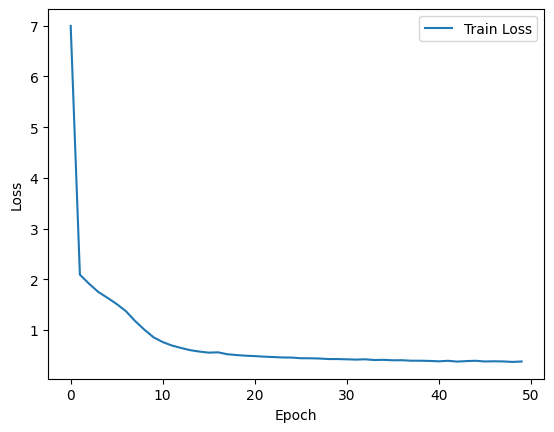

In [48]:

plt.plot(range(num_epochs), train_loss_history, label='Train Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()